In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb  9 12:00:55 2026       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GRID P40-24Q        On   | 00000000:02:00.0  On |                  N/A |
| N/A   N/A    P0    N/A /  N/A |   2474MiB / 24576MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Standard library imports
from datetime import datetime
import os
import random
import shutil
from pathlib import Path
from typing import Tuple, List, Dict, Union

# Scientific computing and numerical operations
import numpy as np

# PyTorch core modules
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary

# PyTorch utilities
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR

# Computer vision and image processing
from PIL import Image
from torchvision import transforms
from torchvision import datasets

# Evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix


In [3]:
# Constants
CLASS_LABELS: Dict[str, int] = {"no_fall": 0, "fall": 1}

# Normalization for 224x224 RGB images
TRANSFORMS_DATASET_NORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
SEED = 42  # Set a fixed seed for reproducibility

random.seed(42)  # Set seed for Python's built-in random module
np.random.seed(42)  # Set seed for NumPy random operations
torch.manual_seed(42)  # Set seed for PyTorch CPU operations
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)  # Set seed for all CUDA devices

torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for cuDNN
torch.backends.cudnn.benchmark = False  # Disable cuDNN benchmarking for consistency


In [5]:
class BinaryFallDataset(Dataset):
    def __init__(self,
                 root_directory_path: Path,
                 subset: str,
                 image_transforms: transforms.Compose = TRANSFORMS_DATASET_NORM) -> None:
        """
        Initialize the dataset with parameters only (no data loading).

        Args:
            root_directory_path (str | Path): Path to dataset directory containing 'train', 'validation', and 'test' subfolders.
            subset (str, optional): Which subset to use: 'train', 'validation', or 'test'. Defaults to 'train'.
            image_transforms (transforms.Compose, optional): Transformations for images. Defaults to [-1, 1] normalization.
        """
        self.root_directory_path = Path(root_directory_path)
        self.subset = subset  # "train", "validation", or "test"
        self.image_transforms = TRANSFORMS_DATASET_NORM
        self.image_file_paths: List[Path] = []
        self.class_labels: List[int] = []
        self.is_data_loaded = False

    def load_dataset(self) -> None:
        """Load image file paths and labels from the dataset directory for the selected subset."""
        if self.is_data_loaded:
            return  # Avoid reloading

        subset_directory = self.root_directory_path / self.subset
        if not subset_directory.exists():
            raise FileNotFoundError(f"Subset directory '{subset_directory}' not found.")

        # For each class (fall, no_fall), collect all PNG files
        for class_name, class_label in CLASS_LABELS.items():
            class_directory = subset_directory / class_name
            if not class_directory.exists():
                raise FileNotFoundError(f"Directory '{class_directory}' not found.")

            image_files_in_class = list(class_directory.rglob("*.png")) + \
                       list(class_directory.rglob("*.jpg")) + \
                       list(class_directory.rglob("*.jpeg"))
            self.image_file_paths.extend(image_files_in_class)
            self.class_labels.extend([class_label] * len(image_files_in_class))

        if not self.image_file_paths:
            raise ValueError("No images found in the dataset directory!")

        self.is_data_loaded = True

    def __len__(self) -> int:
        if not self.is_data_loaded:
            raise RuntimeError("Dataset not loaded. Call `load_dataset()` first.")
        return len(self.image_file_paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Load and transform a single image on demand."""
        if not self.is_data_loaded:
            raise RuntimeError("Dataset not loaded. Call `load_dataset()` first.")

        image_file_path = self.image_file_paths[index]
        class_label = self.class_labels[index]

        image_data = Image.open(image_file_path).convert("RGB")
        image_tensor = self.image_transforms(image_data) if self.image_transforms else image_data

        return image_tensor, class_label

    def get_data_loader(self, batch_size: int = 16, shuffle_data: bool = True) -> DataLoader:
        """Return a DataLoader with minimal RAM usage."""
        if not self.is_data_loaded:
            self.load_dataset()

        return DataLoader(self, batch_size=batch_size, shuffle=shuffle_data, num_workers=2, pin_memory=True, prefetch_factor=2)


In [6]:
def numpy_sigmoid(logits):
    return 1 / (1 + np.exp(-logits))


In [7]:
class MetricsCalculator:
    """Computes and stores binary classification metrics for fall detection using scikit-learn."""
    def __init__(self) -> None:
        """Initialize lists to store predictions and ground truth labels."""
        self.ground_truth: List[int] = []
        self.model_prediction: List[int] = []

    def convert_logits(self, logits: Union[np.ndarray, torch.Tensor], targets: Union[np.ndarray, torch.Tensor], threshold: float = 0.5) -> None:
        """
        Converts raw logits to binary predictions using a sigmoid threshold
        and updates the stored ground truth and prediction lists.

        Args:
            logits (np.ndarray or torch.Tensor): Raw model outputs with shape [batch_size, 1].
            targets (np.ndarray or torch.Tensor): Ground truth labels with shape [batch_size, 1] or [batch_size].
            threshold (float): Threshold for converting probabilities to binary predictions (default: 0.5).
        """
        # Convert PyTorch tensors to NumPy arrays if necessary
        if isinstance(logits, torch.Tensor):
            logits = logits.detach().cpu().numpy()
        if isinstance(targets, torch.Tensor):
            targets = targets.detach().cpu().numpy()

        # Validate input shapes
        if logits.ndim != 2 or logits.shape[1] != 1:
            raise ValueError(f"Logits must have shape [batch_size, 1], got {logits.shape}")
        if targets.shape[0] != logits.shape[0]:
            raise ValueError(f"Targets batch size ({targets.shape[0]}) must match logits ({logits.shape[0]})")

        # Apply sigmoid to convert logits to probabilities
        probabilities = numpy_sigmoid(logits)

        # Threshold probabilities to obtain binary predictions
        predicted_labels = (probabilities >= threshold).astype(int).flatten()

        # Flatten targets (if not already 1D) and update lists
        targets_list = targets.flatten().tolist()
        predicted_labels_list = predicted_labels.tolist()

        self.ground_truth.extend(targets_list)
        self.model_prediction.extend(predicted_labels_list)

    def precision(self) -> float:
        """Compute Precision = TP / (TP + FP)."""
        return precision_score(self.ground_truth, self.model_prediction, zero_division=0)

    def recall(self) -> float:
        """Compute Recall = TP / (TP + FN)."""
        return recall_score(self.ground_truth, self.model_prediction, zero_division=0)

    def f1_score(self) -> float:
        """Compute F1 Score = 2 * (Precision * Recall) / (Precision + Recall)."""
        return f1_score(self.ground_truth, self.model_prediction, zero_division=0)

    def accuracy(self) -> float:
        """Compute Accuracy = (TP + TN) / Total Samples."""
        return accuracy_score(self.ground_truth, self.model_prediction)

    def confusion_matrix(self) -> np.ndarray:
        return confusion_matrix(self.ground_truth, self.model_prediction)

    def reset(self) -> None:
        """Reset stored predictions and ground truth labels."""
        self.ground_truth = []
        self.model_prediction = []




In [8]:
class LightweightResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(LightweightResidualBlock, self).__init__()

        # Depthwise separable convolution for efficiency
        self.depthwise = nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=2,
                                   padding=1, groups=input_channels)
        self.pointwise = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(output_channels)

        # Second depthwise separable convolution
        self.depthwise2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1,
                                    padding=1, groups=output_channels)
        self.pointwise2 = nn.Conv2d(output_channels, output_channels, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(output_channels)

        # Skip connection with projection
        self.skip = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=2),
            nn.BatchNorm2d(output_channels)
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.skip(x)
        out = self.depthwise(x)
        out = self.pointwise(out)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.depthwise2(out)
        out = self.pointwise2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class LightweightFallDetectionCNN(nn.Module):
    def __init__(self):
        super(LightweightFallDetectionCNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.res_block1 = LightweightResidualBlock(32, 64)
        self.res_block2 = LightweightResidualBlock(64, 96)

        self.global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.classifier = nn.Linear(in_features=96, out_features=1, bias=True)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x



In [9]:
# To check if the network is learning first we try to overfit over a small batch

def overfit_single_batch(model, dataloader, criterion, optimizer, scheduler, device, epochs=100, patience=10):
    # Retrieve the batch at index 1 (the second batch)
    single_batch = None
    for index, (images, labels) in enumerate(dataloader):
        if index == 1:
            labels = labels.float().unsqueeze(1)
            single_batch = (images.to(device), labels.to(device))
            break
    if single_batch is None:
        raise RuntimeError("Batch with index 1 not found in the dataloader.")

    batch_images, batch_labels = single_batch

    # Initialize early stopping variables
    best_loss = float('inf')
    patience_counter = 0

    # Overfit on this single batch for the specified number of epochs
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        print(f"Overfit Epoch {epoch+1}/{epochs} - Loss: {loss.item():.6f}")
        scheduler.step(loss)  # Adjust learning rate based on loss

        # Early stopping check
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0  # Reset counter if loss improves
        else:
            patience_counter += 1  # Increase counter if loss doesn't improve

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best loss: {best_loss:.6f}")
            break  # Stop training


In [10]:
class Trainer:
    def __init__(self, model, training_loader, validation_loader, loss_criterion, computing_device, metrics_calculator):
        """Initialize the trainer with model, data, and settings."""
        self.model = model.to(computing_device)
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.loss_criterion = loss_criterion
        self.optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=SCHEDULER_STEP, gamma=SCHEDULER_GAMMA)
        self.computing_device = computing_device
        self.number_of_epochs = NUMBER_OF_EPOCHS
        self.early_stopping_patience = EARLY_STOP_PATIENCE
        self.tensorboard_writer = SummaryWriter()
        self.metrics_calculator = metrics_calculator

        # Create directory in Google Drive to save model
        self.experiment_path = self.create_experiment_folder()

    def create_experiment_folder(self):
        """Creates an experiment folder in Google Drive with timestamp."""

        # Define base path and timestamp
        base_path = "/home/linuxu/Desktop/experiments"
        timestamp = datetime.now().strftime("exp_%d_%m_%Y_%H_%M")
        experiment_path = os.path.join(base_path, timestamp)

        # Create folder if it doesn't exist
        os.makedirs(experiment_path, exist_ok=True)
        print(f"Experiment directory created at: {experiment_path}")

        return experiment_path

    def train_one_epoch(self):
        """Train the model for one epoch and return only the loss."""
        self.model.train()
        total_training_loss = 0.0

        for images, labels in self.training_loader:
            images = images.to(self.computing_device)
            labels = labels.to(self.computing_device).float().unsqueeze(1)  # For BCEWithLogitsLoss

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.loss_criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            batch_size = images.size(0)
            total_training_loss += loss.item() * batch_size

        average_training_loss = total_training_loss / len(self.training_loader.dataset)
        return average_training_loss

    def validate_one_epoch(self):
        """Validate the model and return loss plus all metrics."""
        self.model.eval()
        self.metrics_calculator.reset()
        total_validation_loss = 0.0

        with torch.no_grad():
            for images, labels in self.validation_loader:
                images = images.to(self.computing_device)
                labels = labels.to(self.computing_device).float().unsqueeze(1)
                outputs = self.model(images)
                loss = self.loss_criterion(outputs, labels)

                total_validation_loss += loss.item() * images.size(0)
                self.metrics_calculator.convert_logits(outputs.detach().cpu().numpy(), labels.detach().cpu().numpy())

        average_validation_loss = total_validation_loss / len(self.validation_loader.dataset)
        validation_accuracy = self.metrics_calculator.accuracy()
        validation_precision = self.metrics_calculator.precision()
        validation_recall = self.metrics_calculator.recall()
        validation_f1_score = self.metrics_calculator.f1_score()
        return average_validation_loss, validation_accuracy, validation_precision, validation_recall, validation_f1_score

    def train_full_cycle(self):
        """Run the full training loop with early stopping."""
        best_validation_loss = float('inf')
        epochs_without_improvement = 0
        print("device: ", computing_device)

        for epoch in range(self.number_of_epochs):
            print(f"\n=== Epoch {epoch + 1}/{self.number_of_epochs} ===")

            # Train (only loss) and validate (loss + metrics)
            training_loss = self.train_one_epoch()
            validation_loss, validation_accuracy, validation_precision, validation_recall, validation_f1_score = self.validate_one_epoch()
            self.scheduler.step()

            # Log to TensorBoard
            self.tensorboard_writer.add_scalars("Loss", {"Training": training_loss, "Validation": validation_loss}, epoch)
            self.tensorboard_writer.add_scalar("Validation/Accuracy", validation_accuracy, epoch)
            self.tensorboard_writer.add_scalar("Validation/Precision", validation_precision, epoch)
            self.tensorboard_writer.add_scalar("Validation/Recall", validation_recall, epoch)
            self.tensorboard_writer.add_scalar("Validation/F1 Score", validation_f1_score, epoch)

            # Print metrics (training loss only, full validation metrics)
            print(f"Training   - Loss: {training_loss:.4f}")
            print(f"Validation - Loss: {validation_loss:.4f} | Accuracy: {validation_accuracy:.4f} | Precision: {validation_precision:.4f} | Recall: {validation_recall:.4f} | F1: {validation_f1_score:.4f}")

            # Early stopping and model saving based on validation loss
            if validation_loss < best_validation_loss:
                best_validation_loss = validation_loss
                epochs_without_improvement = 0
                model_save_path = os.path.join(self.experiment_path, "best_model.pth")
                torch.save(self.model.state_dict(), model_save_path)
                print(f"=> Saved best model at: {model_save_path}")
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= self.early_stopping_patience:
                    model_save_path = os.path.join(self.experiment_path, f"model{epoch}.pth")
                    torch.save(self.model.state_dict(), model_save_path)
                    print(f"=> Saved best model at: {model_save_path}")
                    print("Early stopping triggered.")
                    break
            model_save_path = os.path.join(self.experiment_path, f"model{epoch}.pth")
            torch.save(self.model.state_dict(), model_save_path)
            print(f"=> Saved best model at: {model_save_path}")
        self.tensorboard_writer.close()
        print("\nTraining completed!")

In [11]:
# Training hyperparameters
BATCH_SIZE = 16
NUMBER_OF_EPOCHS = 100
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.0

# Early stopping settings
EARLY_STOP_PATIENCE = 8

# Learning rate scheduler settings
SCHEDULER_STEP = 4
SCHEDULER_GAMMA = 0.5

In [12]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

class Evaluation:
    def __init__(self, model, evaluation_loader, loss_criterion, computing_device, metrics_calculator):
        self.model = model.to(computing_device)
        self.evaluation_loader = evaluation_loader
        self.loss_criterion = loss_criterion
        self.computing_device = computing_device
        self.metrics_calculator = metrics_calculator

        # Store scores and labels for ROC
        self.all_labels = []
        self.all_scores = []

    def evaluate(self):
        """Evaluate the model and compute metrics, confusion matrix, and store scores for ROC."""
        self.model.eval()
        self.metrics_calculator.reset()
        total_loss = 0.0
        self.all_labels = []
        self.all_scores = []

        with torch.no_grad():
            for images, labels in self.evaluation_loader:
                images = images.to(self.computing_device)
                labels = labels.to(self.computing_device).float().unsqueeze(1)

                outputs = self.model(images)
                loss = self.loss_criterion(outputs, labels)
                total_loss += loss.item() * images.size(0)

                self.metrics_calculator.convert_logits(
                    outputs.detach().cpu().numpy(),
                    labels.detach().cpu().numpy()
                )

                # Store for ROC
                self.all_labels.extend(labels.detach().cpu().numpy())
                self.all_scores.extend(torch.sigmoid(outputs).detach().cpu().numpy())

        # Compute metrics
        avg_loss = total_loss / len(self.evaluation_loader.dataset)
        accuracy = self.metrics_calculator.accuracy()
        precision = self.metrics_calculator.precision()
        recall = self.metrics_calculator.recall()
        f1 = self.metrics_calculator.f1_score()
        confusion = self.metrics_calculator.confusion_matrix()

        return avg_loss, accuracy, precision, recall, f1, confusion

    def print_evaluation_results(self):
        """Print metrics and confusion matrix."""
        loss, accuracy, precision, recall, f1, confusion = self.evaluate()

        print("\n=== Evaluation Results ===")
        print(f"Loss: {loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nConfusion Matrix:")
        print("[[TN, FP]")
        print(" [FN, TP]]")
        print(f"{confusion[0][0]:4d}  {confusion[0][1]:4d}")
        print(f"{confusion[1][0]:4d}  {confusion[1][1]:4d}")
        print("\nWhere:")
        print(f"TN (True Negatives)  = {confusion[0][0]:4d}")
        print(f"FP (False Positives) = {confusion[0][1]:4d}")
        print(f"FN (False Negatives) = {confusion[1][0]:4d}")
        print(f"TP (True Positives)  = {confusion[1][1]:4d}")
        print("======================")

    def plot_roc_curve(self):
        """Plot ROC curve and compute AUC using stored labels and scores."""
        if not self.all_labels or not self.all_scores:
            print("No data to plot ROC. Run evaluate() first.")
            return

        fpr, tpr, _ = roc_curve(self.all_labels, self.all_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()


In [13]:
# Load trained model
model = LightweightFallDetectionCNN()
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_criterion = nn.BCEWithLogitsLoss()
metrics_calculator = MetricsCalculator()

model.load_state_dict(torch.load("/home/linuxu/Desktop/best_model.pth", weights_only=True))
model.to(computing_device)

/home/linuxu/Desktop/LBFD-Net/lbfdenv/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


LightweightFallDetectionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (res_block1): LightweightResidualBlock(
    (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32)
    (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (pointwise2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps

In [14]:
DATASET_PATH="/home/linuxu/Desktop/"

Fine Tuning on in painting

In [15]:
model = LightweightFallDetectionCNN()
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(
    torch.load("/home/linuxu/Desktop/best_model.pth", map_location=computing_device)
)
model.to(computing_device)

LightweightFallDetectionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (res_block1): LightweightResidualBlock(
    (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32)
    (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (pointwise2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps

In [16]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.res_block2.parameters():
    param.requires_grad = True
    

# Train only classifier
for param in model.classifier.parameters():
    param.requires_grad = True


In [17]:
inpainting_train = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="Inpainting fine tuning/Inpainting Dataset",
    image_transforms=TRANSFORMS_DATASET_NORM
)
inpainting_train.load_dataset()

inpainting_train_loader = inpainting_train.get_data_loader(
    batch_size=16,
    shuffle_data=True
)


In [18]:
inpainting_val = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="Inpainting fine tuning/inpainting_validation",
    image_transforms=TRANSFORMS_DATASET_NORM
)
inpainting_val.load_dataset()

inpainting_val_loader = inpainting_val.get_data_loader(
    batch_size=16,
    shuffle_data=False
)


In [19]:
loss_criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=0.0
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=4,
    gamma=0.5
)


In [20]:
metrics_calculator = MetricsCalculator()

trainer = Trainer(
    model=model,
    training_loader=inpainting_train_loader,   # NEW domain
    validation_loader=inpainting_val_loader,    # OLD domain (protects performance)
    loss_criterion=loss_criterion,
    computing_device=computing_device,
    metrics_calculator=metrics_calculator
)

trainer.train_full_cycle()


Experiment directory created at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_02
device:  cuda

=== Epoch 1/100 ===
Training   - Loss: 1.9531
Validation - Loss: 0.4746 | Accuracy: 0.8778 | Precision: 0.8148 | Recall: 0.9778 | F1: 0.8889
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_02/best_model.pth
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_02/model0.pth

=== Epoch 2/100 ===
Training   - Loss: 1.2234
Validation - Loss: 0.4321 | Accuracy: 0.8444 | Precision: 0.8039 | Recall: 0.9111 | F1: 0.8542
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_02/best_model.pth
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_02/model1.pth

=== Epoch 3/100 ===
Training   - Loss: 0.8808
Validation - Loss: 0.3275 | Accuracy: 0.8778 | Precision: 0.8542 | Recall: 0.9111 | F1: 0.8817
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_02/best_model.pth
=> Saved best mo

In [83]:
model = LightweightFallDetectionCNN()
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(
    torch.load("/home/linuxu/Desktop/experiments/exp_21_01_2026_10_28/best_model.pth", map_location=computing_device)
)
model.to(computing_device)

LightweightFallDetectionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (res_block1): LightweightResidualBlock(
    (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32)
    (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (pointwise2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps

In [ ]:
inpainting_test = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="Inpainting fine tuning/inpainting_test",
    image_transforms=TRANSFORMS_DATASET_NORM
)
inpainting_test.load_dataset()

inpainting_test_loader =  inpainting_test.get_data_loader(
    batch_size=16,
    shuffle_data=False
)


=== Evaluation Results ===
Loss: 0.4267
Accuracy: 0.9222
Precision: 0.9524
Recall: 0.8889
F1 Score: 0.9195

Confusion Matrix:
[[TN, FP]
 [FN, TP]]
  43     2
   5    40

Where:
TN (True Negatives)  =   43
FP (False Positives) =    2
FN (False Negatives) =    5
TP (True Positives)  =   40


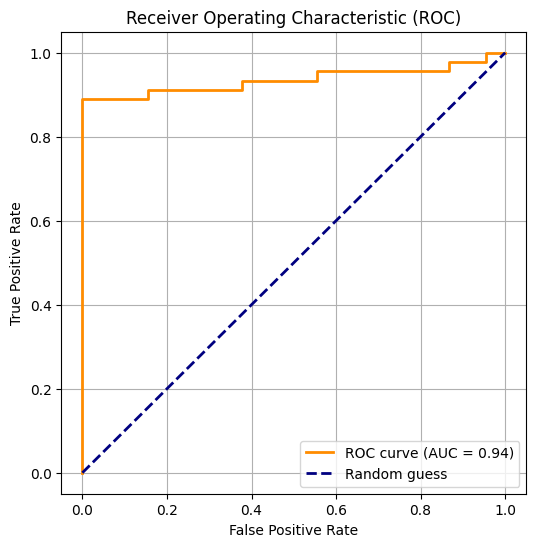

In [85]:
evaluator=Evaluation(
    model,
   inpainting_test_loader,
    loss_criterion,
    computing_device,
    MetricsCalculator()
)
evaluator.print_evaluation_results()
evaluator.plot_roc_curve()




Evaluate on all dataset test set

In [86]:
all_Dataset_test = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="all_Datasets fine tuning/all_Datasets test",
    image_transforms=TRANSFORMS_DATASET_NORM
)
all_Dataset_test.load_dataset()

all_Dataset_test_loader = all_Dataset_test.get_data_loader(
    batch_size=16,
    shuffle_data=False
)


=== Evaluation Results ===
Loss: 0.5262
Accuracy: 0.8593
Precision: 0.8760
Recall: 0.8370
F1 Score: 0.8561

Confusion Matrix:
[[TN, FP]
 [FN, TP]]
 119    16
  22   113

Where:
TN (True Negatives)  =  119
FP (False Positives) =   16
FN (False Negatives) =   22
TP (True Positives)  =  113


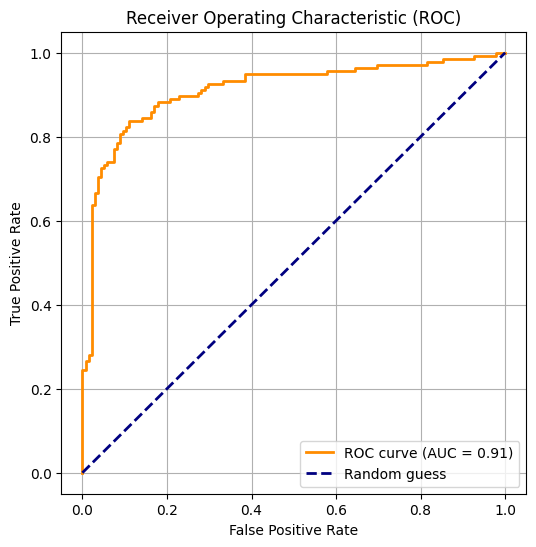

In [87]:
evaluator=Evaluation(
    model,
    all_Dataset_test_loader,
    loss_criterion,
    computing_device,
    MetricsCalculator()
)
evaluator.print_evaluation_results()
evaluator.plot_roc_curve()

fine tuning on Stable 

In [50]:
model = LightweightFallDetectionCNN()
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(
    torch.load("/home/linuxu/Desktop/best_model.pth", map_location=computing_device)
)
model.to(computing_device)

LightweightFallDetectionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (res_block1): LightweightResidualBlock(
    (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32)
    (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (pointwise2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps

In [51]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.res_block2.parameters():
    param.requires_grad = True
    

# Train only classifier
for param in model.classifier.parameters():
    param.requires_grad = True


In [52]:
stable_train = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="Stable fine tuning/Stable_Dataset",
    image_transforms=TRANSFORMS_DATASET_NORM
)
stable_train.load_dataset()

stable_train_loader = stable_train.get_data_loader(
    batch_size=16,
    shuffle_data=True
)


In [53]:
stable_val = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="Stable fine tuning/stable_validation",
    image_transforms=TRANSFORMS_DATASET_NORM
)
stable_val.load_dataset()

stable_val_loader = stable_val.get_data_loader(
    batch_size=16,
    shuffle_data=False
)


In [54]:
loss_criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=0.0
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=4,
    gamma=0.5
)


In [55]:
metrics_calculator = MetricsCalculator()

trainer = Trainer(
    model=model,
    training_loader=stable_train_loader,   # NEW domain
    validation_loader=stable_val_loader,    # OLD domain (protects performance)
    loss_criterion=loss_criterion,
    computing_device=computing_device,
    metrics_calculator=metrics_calculator
)

trainer.train_full_cycle()


Experiment directory created at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_24
device:  cuda

=== Epoch 1/100 ===
Training   - Loss: 1.2578
Validation - Loss: 0.7514 | Accuracy: 0.8000 | Precision: 0.7455 | Recall: 0.9111 | F1: 0.8200
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_24/best_model.pth
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_24/model0.pth

=== Epoch 2/100 ===
Training   - Loss: 0.3692
Validation - Loss: 0.9206 | Accuracy: 0.6889 | Precision: 0.6349 | Recall: 0.8889 | F1: 0.7407
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_24/model1.pth

=== Epoch 3/100 ===
Training   - Loss: 0.3785
Validation - Loss: 1.1164 | Accuracy: 0.6778 | Precision: 0.6111 | Recall: 0.9778 | F1: 0.7521
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_24/model2.pth

=== Epoch 4/100 ===
Training   - Loss: 0.2405
Validation - Loss: 0.7971 | Accuracy: 0.7222 | Precision: 0.6562 |

In [88]:
model = LightweightFallDetectionCNN()
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(
    torch.load("/home/linuxu/Desktop/experiments/exp_21_01_2026_11_44/best_model.pth", map_location=computing_device)
)
model.to(computing_device)

LightweightFallDetectionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (res_block1): LightweightResidualBlock(
    (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32)
    (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (pointwise2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps

In [89]:
stable_test = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="Stable fine tuning/stable_test",
    image_transforms=TRANSFORMS_DATASET_NORM
)
stable_test.load_dataset()

stable_test_loader = stable_test.get_data_loader(
    batch_size=16,
    shuffle_data=False
)



=== Evaluation Results ===
Loss: 0.3728
Accuracy: 0.8667
Precision: 0.8113
Recall: 0.9556
F1 Score: 0.8776

Confusion Matrix:
[[TN, FP]
 [FN, TP]]
  35    10
   2    43

Where:
TN (True Negatives)  =   35
FP (False Positives) =   10
FN (False Negatives) =    2
TP (True Positives)  =   43


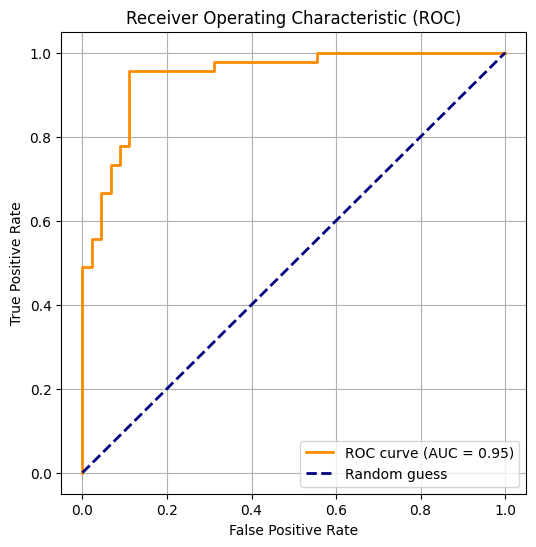

In [90]:
evaluator=Evaluation(
    model,
   stable_test_loader,
    loss_criterion,
    computing_device,
    MetricsCalculator()
)
evaluator.print_evaluation_results()
evaluator.plot_roc_curve()



Evaluate on all dataset test set

In [91]:
all_Dataset_test = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="all_Datasets fine tuning/all_Datasets test",
    image_transforms=TRANSFORMS_DATASET_NORM
)
all_Dataset_test.load_dataset()

all_Dataset_test_loader = all_Dataset_test.get_data_loader(
    batch_size=16,
    shuffle_data=False
)


=== Evaluation Results ===
Loss: 0.7460
Accuracy: 0.8111
Precision: 0.7763
Recall: 0.8741
F1 Score: 0.8223

Confusion Matrix:
[[TN, FP]
 [FN, TP]]
 101    34
  17   118

Where:
TN (True Negatives)  =  101
FP (False Positives) =   34
FN (False Negatives) =   17
TP (True Positives)  =  118


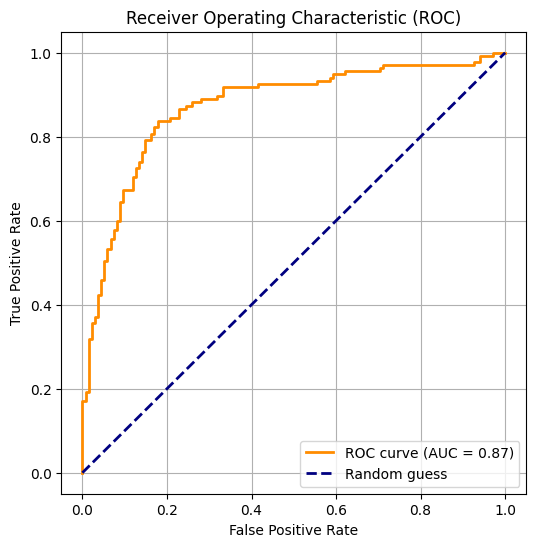

In [92]:
evaluator=Evaluation(
    model,
    all_Dataset_test_loader,
    loss_criterion,
    computing_device,
    MetricsCalculator()
)
evaluator.print_evaluation_results()
evaluator.plot_roc_curve()

fine tuning on nano banana

In [62]:
model = LightweightFallDetectionCNN()
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(
    torch.load("/home/linuxu/Desktop/best_model.pth", map_location=computing_device)
)
model.to(computing_device)

LightweightFallDetectionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (res_block1): LightweightResidualBlock(
    (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32)
    (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (pointwise2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps

In [63]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.res_block2.parameters():
    param.requires_grad = True
    

# Train only classifier
for param in model.classifier.parameters():
    param.requires_grad = True


In [64]:
banana_train = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="Nano Banana fine tuning/Nano Banana Dataset",
    image_transforms=TRANSFORMS_DATASET_NORM
)
banana_train.load_dataset()

banana_train_loader = banana_train.get_data_loader(
    batch_size=16,
    shuffle_data=True
)


In [65]:
banana_val = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="Nano Banana fine tuning/Nano Banana validation",
    image_transforms=TRANSFORMS_DATASET_NORM
)
banana_val.load_dataset()

banana_val_loader = banana_val.get_data_loader(
    batch_size=16,
    shuffle_data=False
)


In [66]:
loss_criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=0.0
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=4,
    gamma=0.5
)


In [67]:
metrics_calculator = MetricsCalculator()

trainer = Trainer(
    model=model,
    training_loader=banana_train_loader,   # NEW domain
    validation_loader=banana_val_loader,    # OLD domain (protects performance)
    loss_criterion=loss_criterion,
    computing_device=computing_device,
    metrics_calculator=metrics_calculator
)

trainer.train_full_cycle()


Experiment directory created at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_55
device:  cuda

=== Epoch 1/100 ===
Training   - Loss: 1.5948
Validation - Loss: 0.6195 | Accuracy: 0.7889 | Precision: 0.7321 | Recall: 0.9111 | F1: 0.8119
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_55/best_model.pth
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_55/model0.pth

=== Epoch 2/100 ===
Training   - Loss: 0.9050
Validation - Loss: 0.6816 | Accuracy: 0.7222 | Precision: 0.8333 | Recall: 0.5556 | F1: 0.6667
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_55/model1.pth

=== Epoch 3/100 ===
Training   - Loss: 0.6768
Validation - Loss: 0.5419 | Accuracy: 0.7556 | Precision: 0.8485 | Recall: 0.6222 | F1: 0.7179
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_55/best_model.pth
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_21_01_2026_18_55/model2.pth

=== Epoch 4/100 ===

In [93]:
model = LightweightFallDetectionCNN()
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(
    torch.load("/home/linuxu/Desktop/experiments/exp_21_01_2026_18_55/best_model.pth", map_location=computing_device)
)
model.to(computing_device)

LightweightFallDetectionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (res_block1): LightweightResidualBlock(
    (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32)
    (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (pointwise2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps

In [94]:
banana_test = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="Nano Banana fine tuning/Nano Banana test",
    image_transforms=TRANSFORMS_DATASET_NORM
)
banana_test.load_dataset()

banana_test_loader = banana_test.get_data_loader(
    batch_size=16,
    shuffle_data=False
)



=== Evaluation Results ===
Loss: 0.3669
Accuracy: 0.8222
Precision: 0.8222
Recall: 0.8222
F1 Score: 0.8222

Confusion Matrix:
[[TN, FP]
 [FN, TP]]
  37     8
   8    37

Where:
TN (True Negatives)  =   37
FP (False Positives) =    8
FN (False Negatives) =    8
TP (True Positives)  =   37


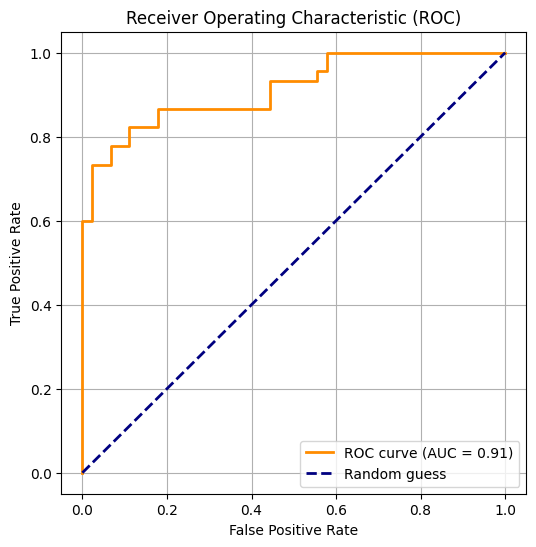

In [95]:
evaluator=Evaluation(
    model,
   banana_test_loader,
    loss_criterion,
    computing_device,
    MetricsCalculator()
)
evaluator.print_evaluation_results()
evaluator.plot_roc_curve()


Evaluate on all dataset test set

In [96]:
all_Dataset_test = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="all_Datasets fine tuning/all_Datasets test",
    image_transforms=TRANSFORMS_DATASET_NORM
)
all_Dataset_test.load_dataset()

all_Dataset_test_loader = all_Dataset_test.get_data_loader(
    batch_size=16,
    shuffle_data=False
)


=== Evaluation Results ===
Loss: 0.5018
Accuracy: 0.8111
Precision: 0.8088
Recall: 0.8148
F1 Score: 0.8118

Confusion Matrix:
[[TN, FP]
 [FN, TP]]
 109    26
  25   110

Where:
TN (True Negatives)  =  109
FP (False Positives) =   26
FN (False Negatives) =   25
TP (True Positives)  =  110


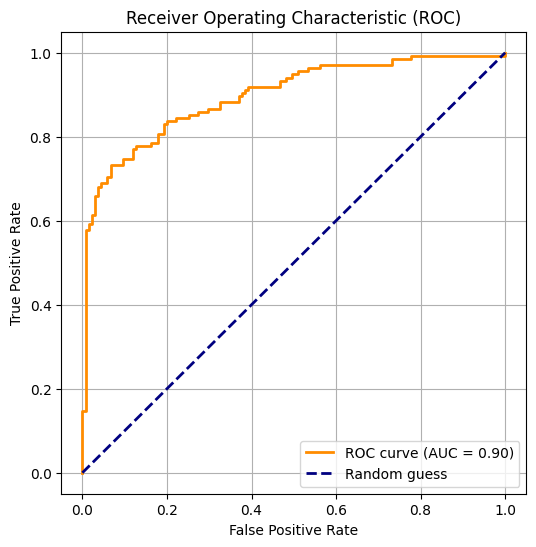

In [97]:
evaluator=Evaluation(
    model,
    all_Dataset_test_loader,
    loss_criterion,
    computing_device,
    MetricsCalculator()
)
evaluator.print_evaluation_results()
evaluator.plot_roc_curve()

fine tuning all datasets

In [73]:
model = LightweightFallDetectionCNN()
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(
    torch.load("/home/linuxu/Desktop/best_model.pth", map_location=computing_device)
)
model.to(computing_device)

LightweightFallDetectionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (res_block1): LightweightResidualBlock(
    (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32)
    (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (pointwise2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps

In [74]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.res_block2.parameters():
    param.requires_grad = True
    

# Train only classifier
for param in model.classifier.parameters():
    param.requires_grad = True


In [75]:
all_Dataset_train = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="all_Datasets fine tuning/all_Datasets",
    image_transforms=TRANSFORMS_DATASET_NORM
)
all_Dataset_train.load_dataset()

all_Dataset_train_loader = all_Dataset_train.get_data_loader(
    batch_size=16,
    shuffle_data=True
)


In [76]:
all_Dataset_val = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="all_Datasets fine tuning/all_Datasets validation",
    image_transforms=TRANSFORMS_DATASET_NORM
)
all_Dataset_val.load_dataset()

all_Dataset_val_loader = all_Dataset_val.get_data_loader(
    batch_size=16,
    shuffle_data=True
)


In [77]:
loss_criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=0.0
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=4,
    gamma=0.5
)


In [78]:
metrics_calculator = MetricsCalculator()

trainer = Trainer(
    model=model,
    training_loader=all_Dataset_train_loader,   # NEW domain
    validation_loader=all_Dataset_val_loader,    # OLD domain (protects performance)
    loss_criterion=loss_criterion,
    computing_device=computing_device,
    metrics_calculator=metrics_calculator
)

trainer.train_full_cycle()


Experiment directory created at: /home/linuxu/Desktop/experiments/exp_22_01_2026_23_15
device:  cuda

=== Epoch 1/100 ===
Training   - Loss: 1.3914
Validation - Loss: 0.6034 | Accuracy: 0.7852 | Precision: 0.8889 | Recall: 0.6519 | F1: 0.7521
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_22_01_2026_23_15/best_model.pth
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_22_01_2026_23_15/model0.pth

=== Epoch 2/100 ===
Training   - Loss: 0.7040
Validation - Loss: 0.6280 | Accuracy: 0.7259 | Precision: 0.7259 | Recall: 0.7259 | F1: 0.7259
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_22_01_2026_23_15/model1.pth

=== Epoch 3/100 ===
Training   - Loss: 0.5512
Validation - Loss: 0.6085 | Accuracy: 0.6815 | Precision: 0.6992 | Recall: 0.6370 | F1: 0.6667
=> Saved best model at: /home/linuxu/Desktop/experiments/exp_22_01_2026_23_15/model2.pth

=== Epoch 4/100 ===
Training   - Loss: 0.4675
Validation - Loss: 0.6867 | Accuracy: 0.6630 | Precision: 0.6964 |

In [80]:
model = LightweightFallDetectionCNN()
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(
    torch.load("/home/linuxu/Desktop/experiments/exp_22_01_2026_23_15/best_model.pth", map_location=computing_device)
)
model.to(computing_device)

LightweightFallDetectionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (res_block1): LightweightResidualBlock(
    (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32)
    (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (pointwise2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps

In [81]:
all_Dataset_test = BinaryFallDataset(
    root_directory_path=Path(DATASET_PATH),
    subset="all_Datasets fine tuning/all_Datasets test",
    image_transforms=TRANSFORMS_DATASET_NORM
)
all_Dataset_test.load_dataset()

all_Dataset_test_loader = all_Dataset_test.get_data_loader(
    batch_size=16,
    shuffle_data=False
)


=== Evaluation Results ===
Loss: 0.5069
Accuracy: 0.8037
Precision: 0.9184
Recall: 0.6667
F1 Score: 0.7725

Confusion Matrix:
[[TN, FP]
 [FN, TP]]
 127     8
  45    90

Where:
TN (True Negatives)  =  127
FP (False Positives) =    8
FN (False Negatives) =   45
TP (True Positives)  =   90


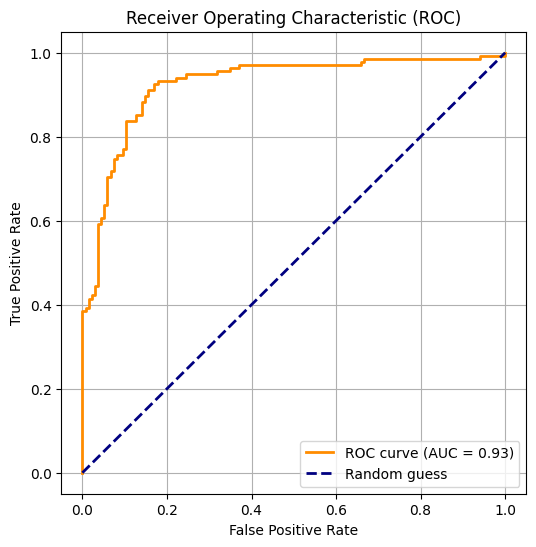

In [82]:
evaluator=Evaluation(
    model,
    all_Dataset_test_loader,
    loss_criterion,
    computing_device,
    MetricsCalculator()
)
evaluator.print_evaluation_results()
evaluator.plot_roc_curve()